# Moving on 🏃‍🏠

I'm about to try to sell my house. As it's the first one I've owned I've never had to choose an estate agent. The problem is that there are a lot of agents available and they all offer the same basic service at a similar price. 

This notebook tries to help me narrow down the field using data scraped from search results pages (SRPs) on www.rightmove.co.uk.

# Choosing a scraping stack

I typically use one of two methods when scraping:
- `requests` & `BeautifulSoup`
- `selenium` & chrome/firefox

If possible I will opt for requests & beautiful soup because you don't have to faff around installing chrome and configuring selenium. Requests  & BS work well for a lot of sites; in particular those with predictable urls and no pop-ups. 

If a site has things like pop-ups or is built with asp then it's often neccessary to go with selenium & chrome. This combination allows you to emulate a human better than `requests` (for example by closing a pop-up).

Because rightmove doesn't pester with popups has a very predictable url strucure it is just right for `requests` & `BeautifulSoup`.

# Making an HTTP request

The first thing we need to do is load a search page from rightmove.co.uk. To start, I go to rightmove in my browser and do a search. The url generated is;

`https://www.rightmove.co.uk/property-for-sale/find.html?locationIdentifier=REGION%5E1362&maxPrice=375000&index=24&includeSSTC=true`

This is an encoded url that can be split into a base url and some parameters that filter rightmoves result set. 

We can split the url into it's parameters using `urllib.parse`:

In [52]:
import urllib.parse
url = 'https://www.rightmove.co.uk/property-for-sale/find.html?locationIdentifier=REGION%5E1362&maxPrice=375000&index=24&includeSSTC=true'
# query = urllib.parse.urlparse(url).query
# urllib.parse.parse_qsl(query)
urllib.parse.urlparse(url)

ParseResult(scheme='https', netloc='www.rightmove.co.uk', path='/property-for-sale/find.html', params='', query='locationIdentifier=REGION%5E1362&maxPrice=375000&index=24&includeSSTC=true', fragment='')

In [28]:
base_url = 'https://www.rightmove.co.uk/property-for-sale/find.html'
params = {'locationIdentifier' : 'REGION^1362',  
          'maxPrice' : 375000, 
          'radius' : 1.0,
          'index' :24,
          'includeSSTC' : True}

Now we are ready to make a GET request to our reconstruted url:

In [29]:
import requests
response = requests.get(base_url, params=params)
response.status_code

200

Status 200 means OKAY so we should have some htlm to play with 🎉🎉🎉

# Extract result cards

Now we have an SRP loaded we need to process it to extract the data we are interested in

The process of parsing HTML generated by the site is very iterative. In short it involves a lot of using Chrome's 'Inspect' tool to examine the code that wraps the data I want to extract! 

In [53]:
# Parse the raw html response into a beautiful soup object
from bs4 import BeautifulSoup
soup = BeautifulSoup(response.text, "lxml")
result_cards = soup.findAll('div', class_ = "l-searchResult is-list ")
print("{} cards found".format(len(result_cards)))

25 cards found


At this point we have an object containing 25 search result cards, so we can progress. 

Finally, I'll write what we did above as a function to use later...

In [8]:
def extract_search_cards(response):
    soup = BeautifulSoup(response.text, "lxml")
    search_result_container = soup.find('div', {'id' : 'l-searchResults', 'class' : 'l-searchResults'})
    result_cards = search_result_container.findAll('div', class_ = "l-searchResult is-list ")
    return result_cards

# Extract content from cards

When rendered in a browser ecah search card looks like this;

![rightmove-search-result](https://user-images.githubusercontent.com/17141221/41064361-3c82a9b6-69d3-11e8-83d4-f7dd13434271.png)

There are various pieces of infomation that I want to extract:
- agent name
- date listed
- price
- whether property is 'reduced'
- whether the property is SOLD

The high-level process for extracting content is:
1. identify the HTML tag that wraps each piece of information
2. Use the beautifulsoup `find` method to select the element through a combination of type and id or class
3. Extract the text through the `.text` property

For example. The following tag contains the agent's name:
```
<span data-bind="text: formattedBranchName" class="propertyCard-branchSummary-branchName"> by Cassidy & Tate, Marshalswick</span>
```

To extract the text we would do:
`card.find('span', { "class" : "propertyCard-branchSummary-branchName"}).text`

This will return `" by Cassidy & Tate, Marshalswick"`. Because every agent name is preceded by `' by '` we simply use python's string indexing to extract everything after the 4th charachter. 

If we repeat  this process for all the pertinent pieces of information we end up with a function to apply to a single card like:

In [9]:
def parse_result_card(card):

    #straight extracts of text
    agent = card.find('span', { "class" : "propertyCard-branchSummary-branchName"}).text[4:]
    price = card.find('div', class_ = 'propertyCard-priceValue').text.strip()
    url = card.find('a', class_='propertyCard-headerLink').get('href')        
    list_date = card.find('span', { "class" : "propertyCard-branchSummary-addedOrReduced"}).text[-10:]

    #Use ternary operator to set a value if target value is found in text
    list_type = 'Reduced' if 'Red' in card.find('span', { "class" : "propertyCard-branchSummary-addedOrReduced"}).text[:7] else 'Added'
    sold = True if 'sold' in card.find('div', class_ = 'propertyCard-tag').text.lower() else False
    offer = True if 'offer' in card.find('div', class_ = 'propertyCard-tag').text.lower() else False

    return (agent, list_type, list_date, price, sold, offer, url)

Now we simply need to iterate over each card with a list comprehension:

In [10]:
page_results = [parse_result_card(card) for card in result_cards]

... and we can check tht the data makes some sense.

In [11]:
page_results[0]

('Brown & Merry, Tring',
 'Added',
 '30/05/2018',
 '£345,000',
 False,
 False,
 '/property-for-sale/property-73512551.html')

Looks good to me!

# Iterating through search pages

So far we've extracted the data we want from a single search result page. But we often need to iterate through multiple pages. 

If we look back at the url parameters we set when making our original GET request we can see there is one called index. This sets the starting point for results. By tinkering with this we can simulate paginating. 

Let's write a function that makes a takes an index and makes a GET request for search results starting at that index. 

In [12]:
def load_search_page(index):
    base_url = 'https://www.rightmove.co.uk/property-for-sale/find.html'
    params = {'locationIdentifier' : 'REGION^1362', 
              'maxPrice' : 400000,
              'radius' : 1.0,
              'index' :index,
              'includeSSTC' : True}
    response = requests.get(base_url, params=params)
    return response

We can now iterate through search

We know when to stop because there are fewer than 24 search results on the page!

In [14]:
output = [] 

i = 0 
last_page = False

while not last_page:
    index = i * 24 #there are 24 results on each page. To avoid duplicates we increment our index by 24 a time.
    response = load_search_page(index)
    srp_cards = extract_search_cards(response)
    results = [parse_result_card(card) for card in srp_cards]
    output.extend(results)
    print("{} results loaded from page {}".format(len(results), i + 1))
    i += 1
    if len(results) < 24:
        last_page = True

25 results loaded from page 1
25 results loaded from page 2
24 results loaded from page 3
24 results loaded from page 4
24 results loaded from page 5
24 results loaded from page 6
13 results loaded from page 7


# Analyse our results

We'll use a pandas dataframe to carry out a descriptive analysis of the data we have scraped:

In [16]:
import pandas as pd
df = pd.DataFrame(output, columns = ['agent', 'add_or_reduce', 'date', 'price', 'sold', 'offer', 'url'])


### A few local agents have the bulk of the market
The data below shows the number of properties each agent avertising in the area has live. It shows there are a lot of small players - including online estate agents - that I'm going to exclude.

In [17]:
df.agent.value_counts()

Michael Anthony, Tring                                           48
Brown & Merry, Tring                                             29
Cesare & Co, Tring                                               25
Hunters, Tring & Surrounding Areas                               11
Nash Partnership, Tring                                          10
Sterling Estate Agents, Tring, Wendover & Berkhamsted             6
Purplebricks, covering London                                     4
The Shared Ownership Shop, Horton                                 4
Little London Estates, Berkhamsted                                2
Tepilo Limited, UK                                                2
Doorsteps.co.uk, National                                         2
Christopher Pallet, Aylesbury                                     2
Connells, Leighton Buzzard                                        1
Home Truth Properties, Hemel Hempstead                            1
Regent Estates, Berkhamsted                     

In [18]:
agents_to_consider = df.agent.value_counts()[df.agent.value_counts()>4].index
df_trimmed = df[df.agent.isin(agents_to_consider)].copy()

### Most properties have been listed (or reduced) in the last 3 months

It's interesting to consider the how long properties have been listed because it might give me some clues about agent performance / activity.

The data I extracted on listing date is stored as a `string`. It's much easier to analyse if it is a `datetime` object. So we need to parse it:

In [19]:
import datetime

# A function to convert the various 'date' values into python datetime types.

def dmystr_to_date(dmy):
    if 'today' in dmy:
        return datetime.date.today()
    if 'yesterday' in dmy:
        return datetime.date.today() - datetime.timedelta(days=1)
    dmy_split = dmy.split('/')
    date_parts = [int(val) for val in dmy_split]
    return datetime.date(date_parts[2], date_parts[1], date_parts[0])

# Apply function to date column and overwrite it
df_trimmed.loc[:, 'date'] = [dmy_to_date(val) for val in df_trimmed['date']]
# df_trimmed.loc[:, 'month_yr'] = [datetime.date(dt.year, dt.month, 1) for dt in df_trimmed['date']]

# Calculate days since listing for each property
TODAY = datetime.date.today()
df_trimmed.loc[:, 'days_since_listing'] = [TODAY - dt for dt in df_trimmed['date']]

Thi can be plotted as a kernel density plot (think smoothed histogram).

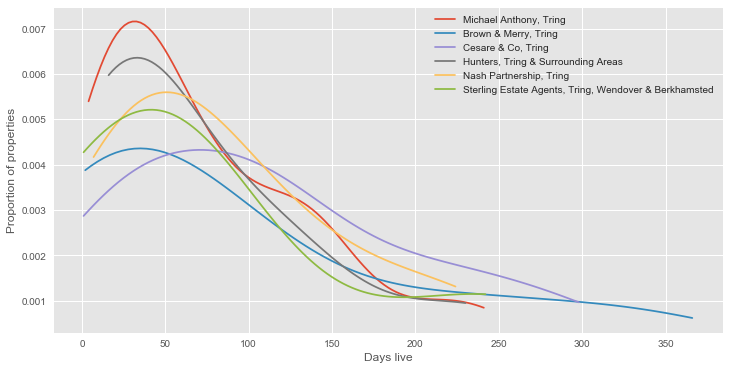

In [20]:
plt.figure(figsize=(12,6))
plt.xlabel('Days live')
plt.ylabel('Proportion of properties')
for agent in agents_to_consider:
    days_live = [delta.days for delta in df_trimmed[df_trimmed['agent'] == agent]['time_live']]
    sns.kdeplot(np.array(days_live), cut=0, label=agent)

Given the low volume of data that contribute to each line, the plot above should be taken with a large pinch of salt.

We can extract a few points of interest;

- It tells us that most properties have been listed (or reduced) in the last 100 days. Given the seasonal nature of property sales, this shouldn't be a surprise. 

- Cesare and co appear to have slightly more older stock than other agents. This might be a negative indicator but given the low volume of properties I'll give them the benefit of the doubt. 

# Selling success

Agents can mark properties as either 'Sold subect to contract' (SSTC) or 'Under offer' (UO). Technically UO is a step before SSTC but it appears that agents use one or the other to mark proporties where a buyer has been found. 

Because there is now way of telling whether these are really different I'm going to merge them...

In [21]:
df_trimmed['sold_or_offer'] = df_trimmed['sold'] | df_trimmed['offer']

Now we can aggregate by agent...

In [22]:
sales_summary = df_trimmed.groupby('agent')['sold_or_offer'].agg([np.mean, len])
sales_summary.columns = ['proportion_sold', 'num_properties']
sales_summary.sort_values(by='proportion_sold', ascending=False)

,proportion_sold,num_properties
agent,,
"Hunters, Tring & Surrounding Areas",0.545455,11
"Cesare & Co, Tring",0.480000,25
"Michael Anthony, Tring",0.312500,48
"Brown & Merry, Tring",0.241379,29
"Nash Partnership, Tring",0.200000,10
"Sterling Estate Agents, Tring, Wendover & Berkhamsted",0.166667,6


# More questions than answers...

From the table above it appears that Cesare & Co are the agent to go with. But there are a whole pile of unanswered questions that might affect this statement:
- Cesare & Co. mark their properties as UNDER OFFER rather than SOLD STC
- Do agents actively take SOLD / UNDER OFFER properties off the site? If so then this behaviour probably varies which would bias. 
- If you look at the types of properties sold Cesare seem to sell a lot of new-build properties.
- We have no idea of what proportion of the asking price was achieved or the failure rate of purchases.

# Wrap up

So clearly, the results of this analysis have to be taken with a pinch of salt. Ultimately I used this data to pick a handful of agents. I spoke to all of them and treated it like I was interviewing them for a job.  My final choice was based on the quality and depth of information they were able to provide and how comfortable I felt with them.